# CarND-Advanced-Lane-Lines

## Imports

In [1]:
import collections
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from abc import ABC, abstractmethod

## Camera Calibration

In [2]:
def calibrate_camera(image_path):
    image_names = glob.glob(image_path)
    # image_names = ["camera_cal/calibration2.jpg"]

    obj_points = []
    img_points = []

    # Object Points are in same z plane, so all z coordinates are 0.
    # Obj_p are corners: (0,0,0), (1,0,0), ..., (7,5,0)
    obj_p = np.zeros((9*6,3), np.float32)
    obj_p[:,0:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for img_name in image_names:
        img = plt.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret_val, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If corners found, append the corners to img_points, append obj_p to object_points.
        if ret_val:
            img_points.append(corners)
            obj_points.append(obj_p)

            # draw_img = cv2.drawChessboardCorners(img, (9,6), corners, ret_val)
            # plt.imshow(draw_img)
            # plt.show()
    return cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)

### Undistort

In [3]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal/calibration*.jpg")

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Test Calibration

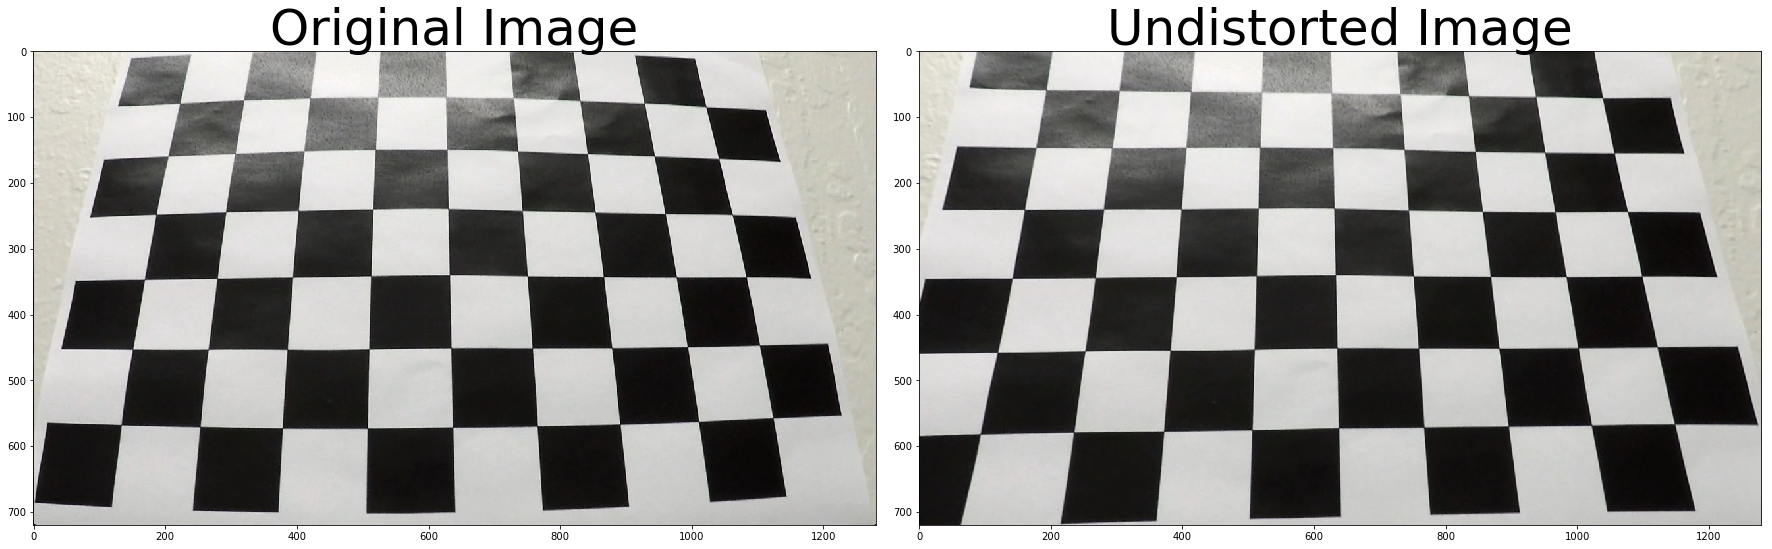

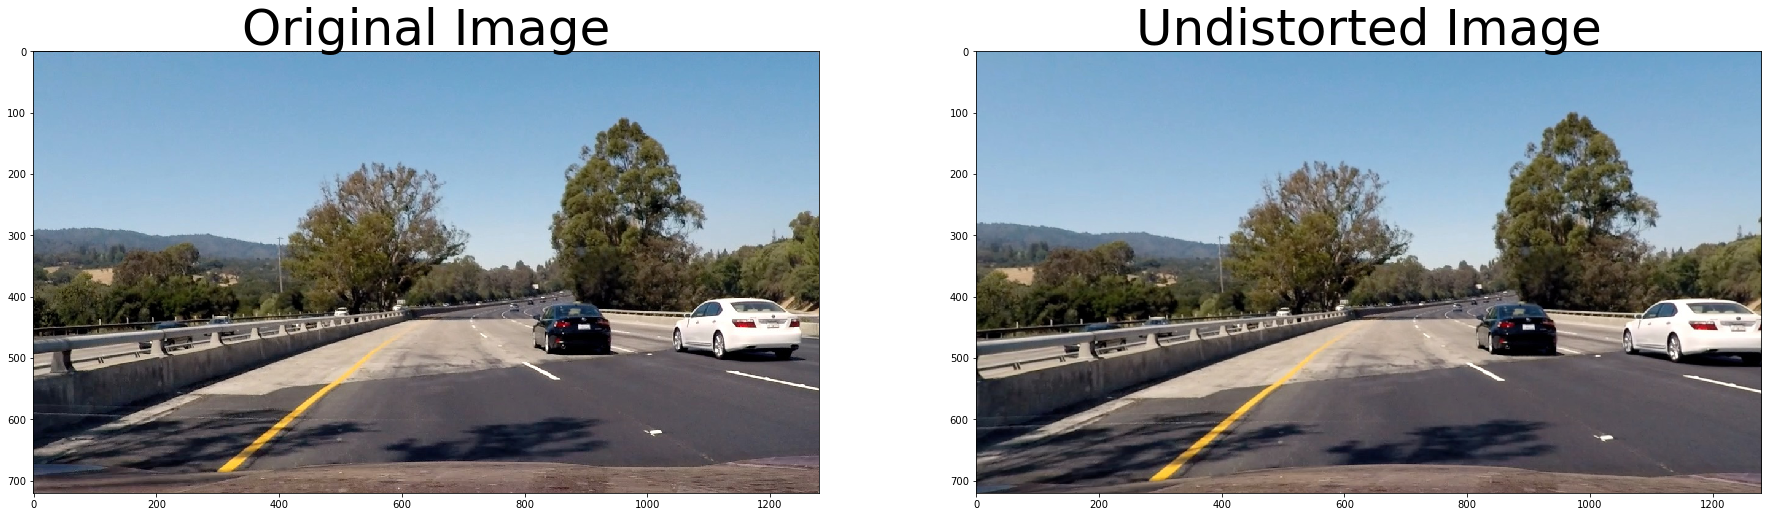

In [22]:
# Get distorted and undistorted calibration images
cal_image = plt.imread("camera_cal/calibration3.jpg")
undistort_cal_img = undistort(cal_image)

# Get distorted and undistorted test images
test_image = plt.imread("test_images/test4.jpg")
undistort_test_img = undistort(test_image)

# Plot distorted and undistorted images
f, (sub_1a, sub_1b) = plt.subplots(1, 2, figsize=(24, 10))
f.tight_layout()
sub_1a.imshow(cal_image)
sub_1a.set_title('Original Image', fontsize=50)
sub_1b.imshow(undistort_cal_img)
sub_1b.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

f, (sub_2a, sub_2b) = plt.subplots(1, 2, figsize=(24, 10))
sub_2a.imshow(test_image)
sub_2a.set_title('Original Image', fontsize=50)
sub_2b.imshow(undistort_test_img)
sub_2b.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Pipeline

### Binary Images

#### Create Binary Images

In [5]:
# Creates binary from channel that lies between threshold parameters.
def create_binary(channel, thresh):
    binary_output = np.zeros_like(channel)
    binary_output[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output
    
# Function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_sob=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x,y = 0,0
    if orient == 'x':
        x = 1
    elif orient == 'y':
        y = 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return create_binary(scaled_sobel, thresh_sob)

# Function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def get_color_and_combined_binary(img, s_thresh=(115,255), v_thresh=(70,255), 
                                  h_thresh=(20,40), x_thresh=(15,255), y_thresh=(30,255)):
    
    # Create Sobel X, Y binaries
    x_sob_binary = abs_sobel_thresh(img, 'x', x_thresh)
    y_sob_binary = abs_sobel_thresh(img, 'y', y_thresh)
    
    # Combine Sobel X and Y binaries into gradient binary
    grad_binary = np.zeros_like(x_sob_binary, np.uint8)
    grad_binary[((x_sob_binary == 1) & (y_sob_binary == 1))] = 1
    
    # Convert to HLS color space and separate the H and S channels channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float32)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    v_channel = hsv[:,:,2]
    
    # Threshold for hue (selecting yellow)
    h_binary = create_binary(h_channel, h_thresh)
    
    # Threshold for value
    v_binary = create_binary(v_channel, v_thresh)
    
    # Threshold for saturation
    s_binary = create_binary(s_channel, s_thresh)
    
    # Create combined color binary from value and saturation binaries
    c_binary = np.zeros_like(v_binary, np.uint8)
    c_binary[((v_binary == 1) & (s_binary == 1))] = 1
    
    yellow_binary = np.zeros_like(h_binary, np.uint8)
    yellow_binary[((h_binary == 1) & (s_binary == 1))] = 1
    
    # Stack each channel
    color_binary = np.dstack((grad_binary, yellow_binary, c_binary))*255
    
    # Create single binary image
    combined = np.zeros_like(c_binary)
    combined[((grad_binary == 1) | (yellow_binary == 1) | (c_binary == 1))] = 1
    return color_binary, combined

#### Test Binary Images

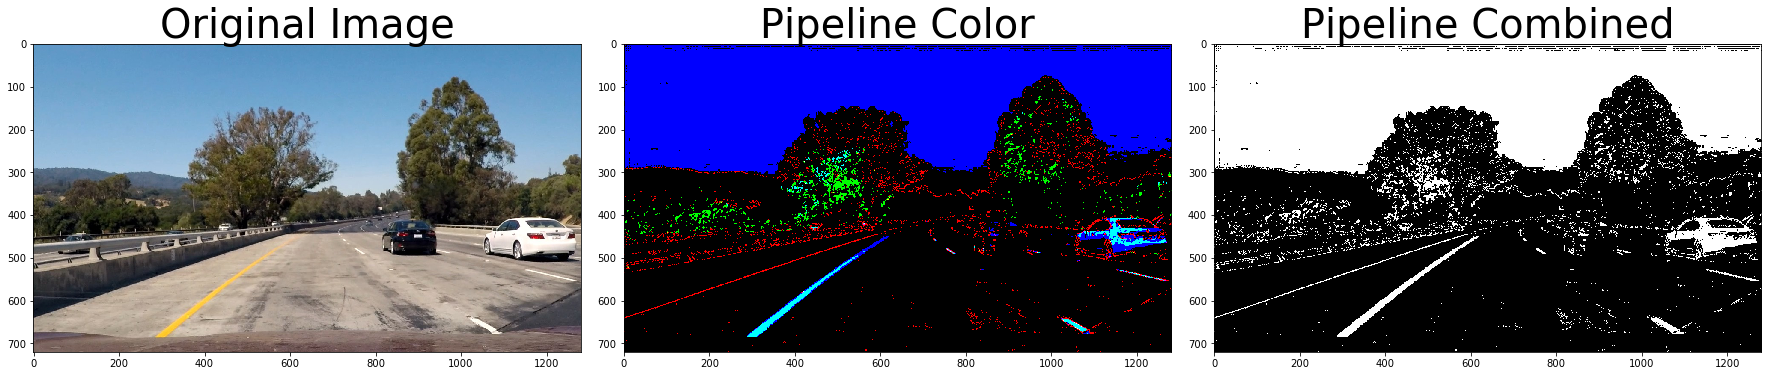

In [6]:
image = plt.imread("test_images/test1.jpg")
color, combined = get_color_and_combined_binary(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color)
ax2.set_title('Pipeline Color', fontsize=40)

ax3.imshow(combined, cmap='gray')
ax3.set_title('Pipeline Combined', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Perspective Transform

#### Boxing the Lane Lines

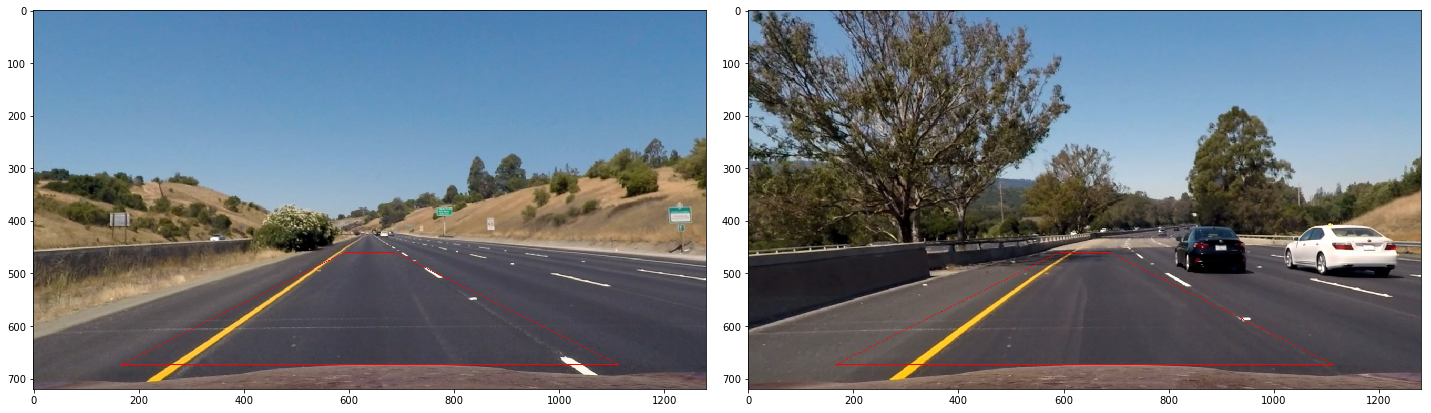

In [9]:
# Read in straight line images
image1 = undistort(plt.imread("test_images/straight_lines1.jpg"))
image2 = undistort(plt.imread("test_images/test6.jpg"))

# Define source corners
width, height = image.shape[1],image.shape[0]
bottom_width_perc = 0.74
top_width_perc = 0.075
height_perc = 0.64
bottom_perc = 0.935
top_y = height*height_perc
bottom_y = height*bottom_perc
top_x_offset = width*top_width_perc/2
bottom_x_offset = width*bottom_width_perc/2
midpoint = width * 0.5

pts = np.int32([[midpoint-top_x_offset,top_y],
                  [midpoint+top_x_offset,top_y],
                  [midpoint+bottom_x_offset,bottom_y],
                  [midpoint-bottom_x_offset,bottom_y]])
pts = pts.reshape((-1,1,2))

# Draw lines boxing in lane lines showing source points chosen
cv2.polylines(image1,[pts],True,(255,0,0))
cv2.polylines(image2,[pts],True,(255,0,0))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(image1)
ax2.imshow(image2)
plt.show()

#### Bird's Eye Transform

In [10]:
# Returns warp perspective of image using M as matrix.
def warp(img, M):
    img_shape = (img.shape[1],img.shape[0])
    return cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)

# Calculates source/destination points for perspective transform, and warps image to birds eye
def perspective_transform(img):
    # Define parameters for calculating source and destination points
    width, height = img.shape[1],img.shape[0]
    bottom_width_perc = 0.74
    top_width_perc = 0.12
    height_perc = 0.64
    bottom_perc = 0.935
    top_y = height*height_perc
    bottom_y = height*bottom_perc
    top_x_offset = width*top_width_perc/2
    bottom_x_offset = width*bottom_width_perc/2
    midpoint = width * 0.5
    offset = width * 0.2
    
    # Define source corners
    src_corners = np.float32([[midpoint-top_x_offset,top_y],
                              [midpoint+top_x_offset,top_y],
                              [midpoint+bottom_x_offset,bottom_y],
                              [midpoint-bottom_x_offset,bottom_y]])
    
    # Define destination corners
    dst_corners = np.float32([[offset,0],[width-offset,0],[width-offset,height],[offset,height]])
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)
    M_inv = cv2.getPerspectiveTransform(dst_corners, src_corners)
    warped = warp(img, M)
    return warped, M, M_inv

#### Test Perspective Transform

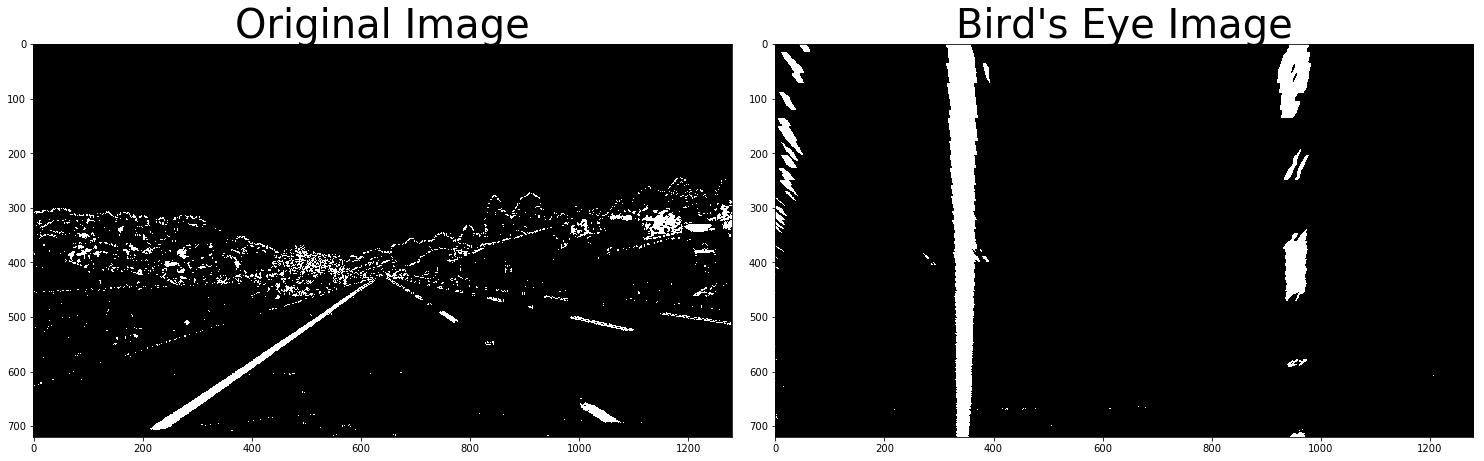

In [12]:
image = plt.imread("test_images/straight_lines1.jpg")
img = undistort(image)
_, bin_img = get_color_and_combined_binary(img)
birds_eye, M, M_inv = perspective_transform(bin_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()

ax1.imshow(bin_img, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(birds_eye, cmap='gray')
ax2.set_title('Bird\'s Eye Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Finding Lane Lines

In [13]:
# Abstract base class for a lane line
class LaneLine(ABC):
    
    def __init__(self):
        self.detected = False               # was the line detected in the last iteration?
        self.n_samples = 15                 # Number of samples to average over
        
        self.best_x_fitted = None           # average x values of the fitted line over the last n iterations
        self.current_x_fitted = None        # current x values of the line
        self.recent_xfitted = []            # x values of the last n fits of the line
        
        self.best_fit = None                # polynomial coefficients averaged over the last n iterations
        self.current_fit = None             # polynomial coefficients for the most recent fit
        self.prev_fits = []                 # array of previous fits
        
        self.allx = None                    # x values for detected line pixels
        self.ally = None                    # y values for detected line pixels
        
        self.radius_of_curvature = None     # radius of curvature of the line in some units
        self.line_base_pos = None           # pixel location of line closest to car
        
        self.ym_per_pix = 20/720            # meters per pixel in y dimension
        self.xm_per_pix = 4/700             # meters per pixel in x dimension
        
        self.margin = 100                   # Set the width of the windows +/- margin
        self.minpix = 200                   # Set minimum number of pixels found to recenter window
        self.nwindows = 10                  # Choose the number of sliding windows
        
        self.window_point_pairs = []        # Pairs of points used for windows
        
    # Caclculates the radius of curvature of the best fitted points    
    def calculate_curve_rad(self, ploty):
        fit_cr = np.polyfit(ploty*self.ym_per_pix, self.best_x_fitted*self.xm_per_pix, 2)
        y_eval = np.max(ploty)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Called for each image in video. Analyses image for lane line, and updates lane line relavent parameters
    def find_lane_line(self, bin_warped_img):
        current_fit = None
        
        # Use windows if line wasn't previously detected, otherwise use current line data
        if self.detected:
            current_fit = self.find_current_fit_from_previous(bin_warped_img)
        else:
            current_fit = self.find_current_fit_with_windows(bin_warped_img)
        
        # TODO: Add Sanity Checks
        self.detected = True
        
        # Set Fits
        self.current_fit = current_fit
        self.prev_fits.append(self.current_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, bin_warped_img.shape[0]-1, bin_warped_img.shape[0])
        self.current_x_fitted = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        self.recent_xfitted.append(self.current_x_fitted)
    
        self.best_x_fitted = np.average(self.recent_xfitted[-self.n_samples:], axis=0)
        self.best_fit = np.polyfit(ploty, self.best_x_fitted, 2)
        
        self.line_base_pos = self.best_x_fitted[-1]
        self.calculate_curve_rad(ploty)
    
    # Finds and returns fit of line using windows method.  Used if line not previously detected.
    def find_current_fit_with_windows(self, bin_warped_img):
        
        # Set window height
        window_height = np.int(bin_warped_img.shape[0]/self.nwindows) # Set height of windows
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = bin_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        x_base = self.find_base(bin_warped_img)
        current_x_base = x_base
        
        all_nonzero_inds = []
        
        # Clear old window points
        self.window_point_pairs = []
        
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y
            win_y_top = bin_warped_img.shape[0] - (window+1)*window_height
            win_y_bottom = bin_warped_img.shape[0] - window*window_height
            win_x_left = current_x_base - self.margin
            win_x_right = current_x_base + self.margin

            win_top_left_point = (win_x_left,win_y_top)
            win_bottom_right_point = (win_x_right,win_y_bottom)
            
            self.window_point_pairs.append((win_top_left_point, win_bottom_right_point))

            # Identify the nonzero pixels in x and y within the window
            nonzero_inds = ((nonzeroy >= win_y_top) & (nonzeroy < win_y_bottom) & (nonzerox >= win_x_left) & (nonzerox < win_x_right)).nonzero()[0]
            # Append these indices to the lists
            all_nonzero_inds.append(nonzero_inds)
            
            # If found > minpix pixels, recenter next window on their mean position
            if len(nonzero_inds) > self.minpix:
                current_x_base = np.int(np.mean(nonzerox[nonzero_inds]))

        # Concatenate the arrays of indices
        all_nonzero_inds = np.concatenate(all_nonzero_inds)

        # Extract left and right line pixel positions
        self.allx = nonzerox[all_nonzero_inds]
        self.ally = nonzeroy[all_nonzero_inds] 

        # Fit a second order polynomial to pixels
        current_fit = np.polyfit(self.ally, self.allx, 2)
        return current_fit
    
    # Finds and returns fit of line inspecting area within margin of previous line
    def find_current_fit_from_previous(self, bin_warped_img):
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = bin_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Find indices of nonzero points that lie within margin of previous line
        nonzero_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) + 
                                     self.current_fit[1]*nonzeroy + 
                                     self.current_fit[2] - self.margin)) 
                        & (nonzerox < (self.current_fit[0]*(nonzeroy**2) + 
                                       self.current_fit[1]*nonzeroy + 
                                       self.current_fit[2] + self.margin))) 
        
        # Again, extract left and right line pixel positions
        self.allx = nonzerox[nonzero_inds]
        self.ally = nonzeroy[nonzero_inds]
        
        # If too few points found, use windows method to find lane lines.
        if len(self.allx) < self.minpix:
            return find_lane_line_with_windows(bin_warped_img)
        else:
            # Fit a second order polynomial to pixels
            current_fit = np.polyfit(self.ally, self.allx, 2)
            return current_fit
    
    # Abstract method that returns base of the line using a histogram
    @abstractmethod
    def find_base(self, bin_warped_img):
        pass

class LeftLaneLine(LaneLine):

    def find_base(self, img):
        # Find histogram of points in bottom half of image
        histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left half of the histogram
        midpoint = np.int(histogram.shape[0]/2)
        return np.argmax(histogram[:midpoint])
        
class RightLaneLine(LaneLine):
    
    def find_base(self, img):
        # Find histogram of points in bottom half of image
        histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
        
        # Find the peak of the right half of the histogram
        midpoint = np.int(histogram.shape[0]/2)
        return np.argmax(histogram[midpoint:]) + midpoint

# Used in pipeline to find lanes and return relavant data.  
# Manages left and right lanes simulataneously.
class LaneFinder():
    
    def __init__(self):
        self.left_lane = LeftLaneLine()
        self.right_lane = RightLaneLine()
        self.lane_lines = [self.left_lane, self.right_lane]
        
    # Called by pipeline, finds lane lines for both left and right lanes.
    def find_lane_lines(self, image):
        for lane_line in self.lane_lines:
            lane_line.find_lane_line(image)
        return self.left_lane, self.right_lane
    
    # Returns the distance from the center of the car to the center of the lane.
    # Negative distance means car is right of center, positive means car is left of center.
    def get_distance_from_center(self, image_width):
        camera_center = (self.left_lane.line_base_pos + self.right_lane.line_base_pos)/2
        return (camera_center - image_width/2)*self.left_lane.xm_per_pix
    
    # Returns the radius of curvature, averaged between the left and right lanes.
    def get_curve_radius(self):
        left_curve_rad = self.left_lane.radius_of_curvature
        right_curve_rad = self.right_lane.radius_of_curvature
        return (left_curve_rad + right_curve_rad)/2.
    
        
        
    

#### Histogram Peaks

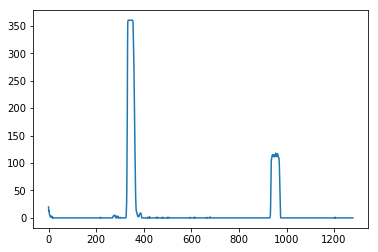

In [14]:
histogram = np.sum(birds_eye[np.int(image.shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.show()

#### Sliding Window

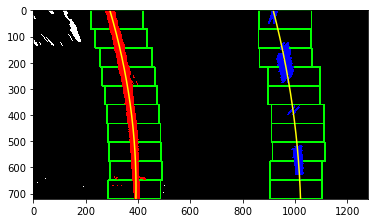

In [15]:
# Read in test image.
image = plt.imread("test2/test0.jpg")
img = undistort(image)
_, bin_img = get_color_and_combined_binary(img)
birds_eye, M, M_inv = perspective_transform(bin_img)

# Find left and right lanes
lane_finder = LaneFinder()
left_lane, right_lane = lane_finder.find_lane_lines(birds_eye)

# Create an output image to draw on and visualize the result
channel = np.uint8(birds_eye*255)
out_img = np.dstack((channel, channel, channel))

# Draw the windows on the visualization image
for lane in [left_lane, right_lane]:
    for (top_left_corner, bottom_right_corner) in lane.window_point_pairs:
        cv2.rectangle(out_img,top_left_corner,bottom_right_corner,(0,255,0), 5)   
        
# Generate x and y values for plotting
ploty = np.linspace(0, birds_eye.shape[0]-1, birds_eye.shape[0])

out_img[left_lane.ally, left_lane.allx] = [255, 0, 0]
out_img[right_lane.ally, right_lane.allx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_lane.best_x_fitted, ploty, color='yellow')
plt.plot(right_lane.best_x_fitted, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

#### Finding Lines Given Previous Fit

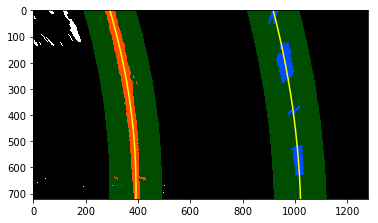

In [23]:
# Find lanes again using the previous lanes found as reference.
left_lane, right_lane = lane_finder.find_lane_lines(birds_eye)

ploty = np.linspace(0, birds_eye.shape[0]-1, birds_eye.shape[0])

# Create an image to draw on and an image to show the selection window
channel = np.uint8(birds_eye*255)
out_img2 = np.dstack((channel, channel, channel))
window_img = np.zeros_like(out_img2)
# Color in left and right line pixels
out_img2[left_lane.ally, left_lane.allx] = [255, 0, 0]
out_img2[right_lane.ally, right_lane.allx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_lane.best_x_fitted-left_lane.margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane.best_x_fitted+left_lane.margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_lane.best_x_fitted-right_lane.margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane.best_x_fitted+right_lane.margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_lane.best_x_fitted, ploty, color='yellow')
plt.plot(right_lane.best_x_fitted, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Project Lines On Original Image

In [17]:
# Returns lane lines (filled) projected on to the unwarped (non birds eye) view.
def project_lines_on_unwarped(unwarped_img, bin_warped_img, left_lane_line, right_lane_line, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, bin_warped_img.shape[0]-1, bin_warped_img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_lane_line.best_x_fitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane_line.best_x_fitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, M_inv)
    # Combine the result with the original image
    result = cv2.addWeighted(unwarped_img, 1, newwarp, 0.3, 0)
    return result



#### Test Project Lane Lines

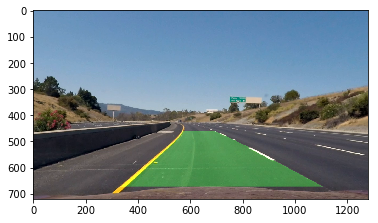

In [18]:
# Read in image, undistort, warp to birds-eye
image = plt.imread("test2/test0.jpg")
image = image[:,:,:3]
img = undistort(image)
_, bin_img = get_color_and_combined_binary(img)
birds_eye, M, M_inv = perspective_transform(bin_img)

# Find lane lines in birds eye image using LaneFinder
lane_finder = LaneFinder()
left_lane, right_lane = lane_finder.find_lane_lines(birds_eye)

# Project lane lines onto unwarped image
final_image = project_lines_on_unwarped(img, birds_eye, left_lane, right_lane, M_inv)
plt.imshow(final_image)
plt.show()

In [19]:
lf = LaneFinder()

# Called by fl_image to render lane lines on each image frame in video file
def pipeline(frame):
    # plt.imsave("test_c/test{}.jpg".format(pipeline.counter), frame)
    
    # Undistort image, get binary of image, and transform biary to birds eye view
    undistorted = undistort(frame)
    _, binary_image = get_color_and_combined_binary(undistorted)
    binary_warped, m, m_inv = perspective_transform(binary_image)

    # Find left/right lane lines using LaneFinder
    left_line, right_line = lf.find_lane_lines(binary_warped)
    
    # Project the lane lines onto the unwarped image
    response = project_lines_on_unwarped(undistorted, binary_warped, left_line, right_line, m_inv)
    
    # Calculate curvature radius and offset
    curve_rad = lf.get_curve_radius()
    center_diff = lf.get_distance_from_center(binary_warped.shape[1])
    side = "left" if center_diff >= 0 else "right"
    
    # Write curvature radius and offset on final image
    white = (255,255,255)
    cv2.putText(response, "Radius of Curvature: {}m".format(round(curve_rad,3)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, white, 2)
    cv2.putText(response, "Vehicle is {}m {} of center".format(round(abs(center_diff),3), side), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, white, 2)

    # plt.imsave("result/test{}.jpg".format(pipeline.counter), response)
    # pipeline.counter += 1
    return response
# pipeline.counter = 0

In [20]:
from moviepy.editor import VideoFileClip

video_output_filename = 'project_video.mp4'
clip1 = VideoFileClip("project_video_source.mp4")
video_clip = clip1.fl_image(pipeline)
video_clip.write_videofile(video_output_filename, audio=False)

[MoviePy] >>>> Building video project_video_lanes_drawn.mp4
[MoviePy] Writing video project_video_lanes_drawn.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  5.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes_drawn.mp4 

